# ДЗ Линейная регрессия

В данном задании мы рассмотрим набор данных об учащихся, собранный в 2006 году в одной из школ Португалии. Данные представлены в неудобном для машинного обучения виде, и содержат мусор. Ваша задача &mdash; привести их к надлежащему виду и обучить на них простую модель.

Данные состоят из четырех файлов:
- data.csv &mdash; основная таблица с информацией о учащихся
- scores.csv &mdash; список финальных оценок по одному из предметов (20-балльная шкала переведенная в проценты)
- attendance.csv &mdash; таблица посещений занятий по этому предмету
- school_support.txt &mdash; список учащихся, которым оказывается финансовая поддержка

Ваша задача &mdash; построить модель для предсказания финальных оценок исходя из всех остальных данных и проверить качество ее работы с помощью кросс-валидации. В качестве алгоритма мы будем использовать линейную регрессию, а качество будем измерять по метрике RMSE.

Расшифровка столбцов в data.csv для справки:
- age &mdash; возраст
- Medu &mdash; уровень образования матери (по некоторой условной шкале)
- Fedu &mdash; уровень образования отца (по некоторой условной шкале)
- traveltime &mdash; время в пути до школы (1 – < 15 мин., 2 – от 15 до 30 мин., 3 – от 30 мин. to 1 ч.
или 4 – > 1 ч.)
- studytime &mdash; время, затрачиваемое на занятия вне школы (1 – < 2 ч., 2 – от 2 до 5 ч., 3 – от 5 до 10 ч. или 4 – > 10 ч.)
- famrel &mdash; насколько хорошие отношения в семье у учащегося (по некоторой условной шкале)
- freetime &mdash; количество свободного времени вне школы (по некоторой условной шкале)
- goout &mdash; время, затрачиваемое на общение с друзьями (по некоторой условной шкале)
- Dalc &mdash; количество употребления алкоголя в учебные дни (по некоторой условной шкале)
- Walc &mdash; количество употребления алкоголя в неучебные дни (по некоторой условной шкале)
- health &mdash; уровень здоровья (по некоторой условной шкале)
- sex_M &mdash; пол: мужской (1) или женский (0)
- address_U &mdash; живет ли учащийся в городе (1) или в пригороде (0)
- famsize_LE3 &mdash; размер семьи: не больше 3 человек (1) или больше (0)
- Pstatus_T &mdash; живут ли родители вместе (1) или отдельно (0)
- nursery &mdash; посещал ли учащийся детский сад
- plans_university &mdash; планирует ли учащийся поступать в университет (-1 или 1)
- past_failures &mdash; количество неудовлетворительных оценок по другим предметам ранее (от 0 до 4)

*Примечание. Несколько признаков в данных содержат ошибки/проблемы/некорректности. Эти проблемы нужно исправить. Для
проверки &mdash; всего в данных таких проблем четыре.*

### Задача 1: сломанный признак (а может и не один)
__(1 балл)__

Загрузите таблицу data.csv.

Найдите в данных сломанный признак (он не соответствует описанию) и исправьте его.

In [1]:
# заметим, что ошибки явно есть в последних 2 столбцах, так как они соединены. В первом столбце вместо возвраста у некоторых школьников записан год рождения, а в 4 столбце вместо условных едениц у некоторых написанно время. Давайте пофикмим все эти недачеты.
import pandas as pd

def make_to_num(time):
    time = int(time)
    if time <= 4:
        return time
    if time < 15:
        return 1
    if time < 30:
        return 2
    if time < 60:
        return 3
    return 4

def sign(num):
    num = int(num)
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

# Чтение данных
data = pd.read_csv('data.csv')

# Переименование последнего столбца и добавление нового
data.columns = list(data.columns[:-1]) + ['plans_university']
data['past_failures'] = 0

# Применение преобразований к данным
last_col = data.columns[-2]  # предпоследний столбец (plans_university)
first_col = data.columns[0]  # первый столбец
third_col = data.columns[3]  # четвертый столбец (индекс 3)

# Преобразования для каждой строки
for i in range(len(data)):
    # Обработка последнего столбца
    val = int(data.loc[i, last_col])
    data.loc[i, last_col] = sign(val)
    data.loc[i, 'past_failures'] = val - 10 * sign(val)
    
    # Обработка первого столбца
    if int(data.loc[i, first_col]) > 1000:
        data.loc[i, first_col] = 2006 - int(data.loc[i, first_col])
    
    # Обработка четвертого столбца
    data.loc[i, third_col] = make_to_num(data.loc[i, third_col])

# Запись данных
data.to_csv('new_data.csv', index=False, encoding='utf-8')

### Задача 2: пропуски в данных 
__(1 балл)__

Проверьте, есть ли в данных пропуски (значения NaN). Замените все пропущенные значения на среднее значение этого признака по столбцу.

*Hint: изучите в pandas функции loc, isnull, а также передачу булевых массивов в качестве индексов.*

In [2]:
import pandas as pd
import numpy as np

def make_to_num(time):
    time = int(time)
    if time <= 4:
        return time
    if time < 15:
        return 1
    if time < 30:
        return 2
    if time < 60:
        return 3
    return 4

def sign(num):
    num = int(num)
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

# Чтение данных
data = pd.read_csv('data.csv')

# ЗАМЕНА NaN НА СРЕДНИЕ ЗНАЧЕНИЯ
# print("Пропуски до замены:")
# print(data.isnull().sum())

for column in data.columns:
    if data[column].dtype in [np.number]:  # только числовые столбцы
        column_mean = data[column].mean()
        data.loc[data[column].isnull(), column] = column_mean

# print("Пропуски после замены:")
# print(data.isnull().sum())

# Переименование последнего столбца и добавление нового
data.columns = list(data.columns[:-1]) + ['plans_university']
data['past_failures'] = 0

# Применение преобразований к данным
last_col = data.columns[-2]  # предпоследний столбце (plans_university)
first_col = data.columns[0]  # первый столбец
third_col = data.columns[3]  # четвертый столбец (индекс 3)

# Преобразования для каждой строки
for i in range(len(data)):
    # Обработка последнего столбца
    val = int(data.loc[i, last_col])
    data.loc[i, last_col] = sign(val)
    data.loc[i, 'past_failures'] = val - 10 * sign(val)
    
    # Обработка первого столбца
    if int(data.loc[i, first_col]) > 1000:
        data.loc[i, first_col] = 2006 - int(data.loc[i, first_col])
    
    # Обработка четвертого столбца
    data.loc[i, third_col] = make_to_num(data.loc[i, third_col])

# Запись данных
data.to_csv('new_data.csv', index=False, encoding='utf-8')

C:\Users\user\AppData\Local\Temp\ipykernel_20956\460677872.py:32: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if data[column].dtype in [np.number]:  # только числовые столбцы
C:\Users\user\AppData\Local\Temp\ipykernel_20956\460677872.py:32: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if data[column].dtype in [np.number]:  # только числовые столбцы
C:\Users\user\AppData\Local\Temp\ipykernel_20956\460677872.py:32: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if data[column].dtype in [np.number]:  # только числовые столбцы
C:\Users\user\AppData\Local\Temp\ipykernel_20956\460677872.py:32: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated

### Задача 3: кросс-валидация для исходных данных
__(1 балл)__

Загрузите файл scores.csv и протестируйте, как линейная регрессия предсказывает ответ сейчас (с помощью кросс-валидации).

*Hint: воспользуйтесь sklearn.linear_model и sklearn.model_selection.*

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression       
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

data = pd.read_csv('new_data.csv')
res = pd.read_csv('scores.csv')

X_train, X_test, y_train, y_test = train_test_split(data, res, test_size=0.3, random_state=42)
model = LinearRegression()  # Создание экземпляра модели линейной регрессии
model.fit(X_train, y_train) # Обучение модели на обучающих данных
y_pred = model.predict(X_test)  # Прогнозирование цен на тестовых данных
rmse = root_mean_squared_error(y_test, y_pred)  # Расчет RMSE 
print(f'RMSE модели: {rmse:.10f}')           # Вывод значения ошибки


RMSE модели: 16.6583658569


### Задача 4: нормализация данных
__(1 балл)__

Нормализуйте данные и повторите предыдущий пункт

*Hint: воспользуйтесь sklearn.linear_model и sklearn.model_selection.*

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression       
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('new_data.csv')
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)
res = pd.read_csv('scores.csv')


X_train, X_test, y_train, y_test = train_test_split(data, res, test_size=0.3, random_state=42)
model = LinearRegression()  # Создание экземпляра модели линейной регрессии
model.fit(X_train, y_train) # Обучение модели на обучающих данных
y_pred = model.predict(X_test)  # Прогнозирование цен на тестовых данных
rmse = root_mean_squared_error(y_test, y_pred)  # Расчет RMSE 
print(f'RMSE модели: {rmse:.10f}')           # Вывод значения ошибки


RMSE модели: 16.6583658569


### Задача 5: полные данные
__(3 балла)__

Воспользуйтесь файлами attendance.csv и school_support.txt для того, чтобы добавить новые признаки в данные. Желательно по максимуму использовать возможности pandas для упрощения преобразований.

school_suport число в строке значит что i-ый школьник из исходной таблицы получал мат помощь

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression       
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('new_data.csv')
atten = pd.read_csv('attendance.csv')
# Считаем количество '+' в каждой строке
atten_counts = atten.apply(lambda row: str(row).count('+'), axis=1)
# Добавляем как новый столбец
data['attendance'] = atten_counts
indices_list = []
with open('school_support.txt', 'r') as file:
    indices_list = [int(line.strip()) for line in file]
# Создайте новый столбец в DataFrame, проверяя наличие индекса в списке
data["math_help"] = np.where(data.index.isin(indices_list), 1, 0)


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)
res = pd.read_csv('scores.csv')


X_train, X_test, y_train, y_test = train_test_split(data, res, test_size=0.3, random_state=42)
model = LinearRegression()  # Создание экземпляра модели линейной регрессии
model.fit(X_train, y_train) # Обучение модели на обучающих данных
y_pred = model.predict(X_test)  # Прогнозирование цен на тестовых данных
rmse = root_mean_squared_error(y_test, y_pred)  # Расчет RMSE 
print(f'RMSE модели: {rmse:.10f}')           # Вывод значения ошибки


RMSE модели: 16.4719875071


### Задача 6: борьба с выбросами
__(3 балла)__

Качество предсказания может ухудшаться, если в данных присутствуют корректные значения признаков (с точки зрения чтения данных и применения методов), но не соответствующие реальным объектам. Например, данные могли быть введены в неверном формате, а потом слишком грубо приведены к общему виду, из-за чего ошибка не была замечена.
Попробуем от такого избавиться &mdash; а для этого такие объекты нужно сначала найти. Конечно, нам еще недоступны многие продвинутые способы, но давайте попробуем обойтись простыми.

Первый способ это сделать &mdash; посмотреть для каждого признака на распределение его значений и проверить крайние значения на правдоподобность.

*Hint 1: используйте функцию DataFrame.hist*

*Hint 2: в описании датасета выше есть информация, необходимая для восстановления правильных значений*

RMSE модели: 16.0934315384


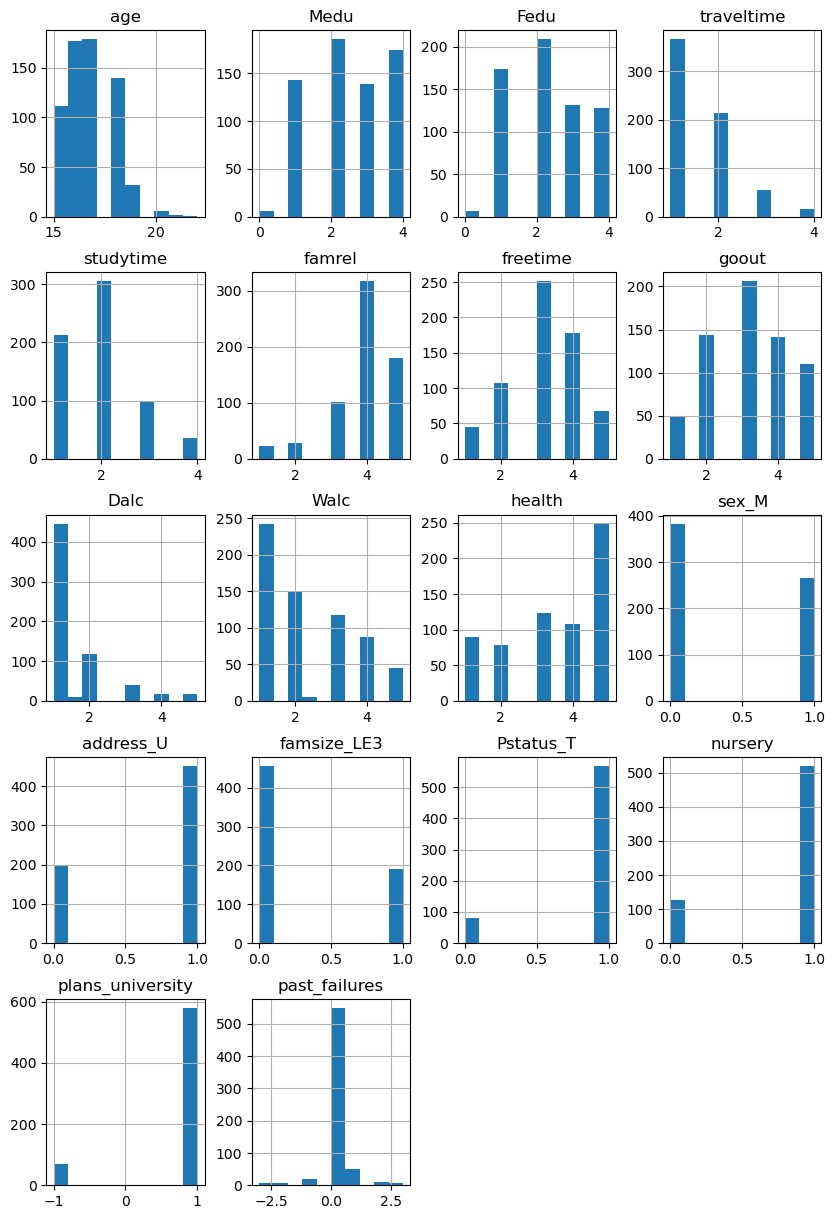

In [1]:
# в качестве явно некоректных значений уберем школьников, которым больше 18 лет. Ведь данные значения означают, что они оставались на второй год, что может ухудшить наше предсказание

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression       
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('new_data.csv')
data.hist(figsize=(10,15))
atten = pd.read_csv('attendance.csv')
# Считаем количество '+' в каждой строке
atten_counts = atten.apply(lambda row: str(row).count('+'), axis=1)
# Добавляем как новый столбец
data['attendance'] = atten_counts
indices_list = []
with open('school_support.txt', 'r') as file:
    indices_list = [int(line.strip()) for line in file]
# Создайте новый столбец в DataFrame, проверяя наличие индекса в списке
data["math_help"] = np.where(data.index.isin(indices_list), 1, 0)
res = pd.read_csv('scores.csv')
res = res[data['age'] <= 18]
data = data[data['age'] <= 18]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)

X_train, X_test, y_train, y_test = train_test_split(data, res, test_size=0.3, random_state=42)
model = LinearRegression()  # Создание экземпляра модели линейной регрессии
model.fit(X_train, y_train) # Обучение модели на обучающих данных
y_pred = model.predict(X_test)  # Прогнозирование цен на тестовых данных
rmse = root_mean_squared_error(y_test, y_pred)  # Расчет RMSE 
print(f'RMSE модели: {rmse:.10f}')           # Вывод значения ошибки


Другой простой способ найти выбросы &mdash; сделать предсказание на всех объектах и посмотреть на объекты с наибольшей ошибкой. Обратите внимание, что просто удалять все объекты с высокой ошибкой нельзя &mdash; это, конечно, хороший способ добиться меньшей ошибки (на данной выборке), но одновременно вы ухудшите обобщающую способность алгоритма. Вместо этого вам нужно найти однозначно ошибочные записи и их исправить.

*Hint: возможно, все проблемы уже были найдены первым способом; для проверки &mdash; в сумме здесь нужно исправить 3 проблемы.*

In [7]:
# в качестве явно некоректных значений уберем школьников, которым больше 18 лет. Ведь данные значения означают, что они оставались на второй год, что может ухудшить наше предсказание

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression       
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('new_data.csv')
atten = pd.read_csv('attendance.csv')
# Считаем количество '+' в каждой строке
atten_counts = atten.apply(lambda row: str(row).count('+'), axis=1)
# Добавляем как новый столбец
data['attendance'] = atten_counts
indices_list = []
with open('school_support.txt', 'r') as file:
    indices_list = [int(line.strip()) for line in file]
# Создайте новый столбец в DataFrame, проверяя наличие индекса в списке
data["math_help"] = np.where(data.index.isin(indices_list), 1, 0)
res = pd.read_csv('scores.csv')
res = res[data['age'] <= 18]
data = data[data['age'] <= 18]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)

model_del = LinearRegression()
model_del.fit(data,res)

# УДАЛЕНИЕ ОБЪЕКТОВ С ОШИБКОЙ БОЛЕЕ 20%
y_pred = model_del.predict(data)
errors = np.abs(res.values.flatten() - y_pred.flatten())
error_percent = errors / res.values.flatten() * 100

# Фильтруем данные (ошибка <= 20%)
good_mask = error_percent <= 50
data_clean = data[good_mask]
res_clean = res[good_mask]


X_train, X_test, y_train, y_test = train_test_split(data_clean, res_clean, test_size=0.3, random_state=42)
model = LinearRegression()  # Создание экземпляра модели линейной регрессии
model.fit(X_train, y_train) # Обучение модели на обучающих данных
y_pred = model.predict(X_test)  # Прогнозирование цен на тестовых данных
rmse = root_mean_squared_error(y_test, y_pred)  # Расчет RMSE 
print(f'RMSE модели: {rmse:.10f}')           # Вывод значения ошибки


RMSE модели: 10.6823886188


C:\Users\user\AppData\Local\Temp\ipykernel_20956\272379037.py:35: RuntimeWarning: divide by zero encountered in divide
  error_percent = errors / res.values.flatten() * 100


### Финальное предсказание

Проведите предсказание еще раз и сравните качество с исходным.

In [8]:
# в качестве явно некоректных значений уберем школьников, которым больше 18 лет. Ведь данные значения означают, что они оставались на второй год, что может ухудшить наше предсказание

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression       
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('new_data.csv')
atten = pd.read_csv('attendance.csv')
# Считаем количество '+' в каждой строке
atten_counts = atten.apply(lambda row: str(row).count('+'), axis=1)
# Добавляем как новый столбец
data['attendance'] = atten_counts
indices_list = []
with open('school_support.txt', 'r') as file:
    indices_list = [int(line.strip()) for line in file]
# Создайте новый столбец в DataFrame, проверяя наличие индекса в списке
data["math_help"] = np.where(data.index.isin(indices_list), 1, 0)
res = pd.read_csv('scores.csv')
res = res[data['age'] <= 18]
data = data[data['age'] <= 18]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)

model_del = LinearRegression()
model_del.fit(data,res)

# УДАЛЕНИЕ ОБЪЕКТОВ С ОШИБКОЙ БОЛЕЕ 50%
y_pred = model_del.predict(data)
errors = np.abs(res.values.flatten() - y_pred.flatten())
error_percent = errors / res.values.flatten() * 100

# Фильтруем данные (ошибка <= 50)
good_mask = error_percent <= 50
data_clean = data[good_mask]
res_clean = res[good_mask]


X_train, X_test, y_train, y_test = train_test_split(data_clean, res_clean, test_size=0.3, random_state=42)
model = LinearRegression()  # Создание экземпляра модели линейной регрессии
model.fit(X_train, y_train) # Обучение модели на обучающих данных
y_pred = model.predict(X_test)  # Прогнозирование цен на тестовых данных
rmse = root_mean_squared_error(y_test, y_pred)  # Расчет RMSE 
print(f'RMSE модели: {rmse:.10f}')           # Вывод значения ошибки


RMSE модели: 10.6823886188


C:\Users\user\AppData\Local\Temp\ipykernel_20956\2791132565.py:35: RuntimeWarning: divide by zero encountered in divide
  error_percent = errors / res.values.flatten() * 100


### Вывод
Можно заметить, что если убрать из базы данных школьников, которые явно не являются стандартным случаем(школьники остававшиеся на 2 год) то предсказание несколько улучшиться. Если же убрать школьников которые сильно отличаются от других по непонятным характеристикам(на которых наше предстказание работает плохо).